In [2]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from functools import partial
import pyForwardFolding as pyFF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
data = pd.read_parquet("../../NNMFit_testdata/src/NNMFit_testdata/data/datasets/Toise_ToyTracks/dataframe.parquet")

input_variables = {
    "true_energy": jnp.asarray(data.true_e),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "baseline_weight": jnp.asarray(data.fluxless_weight),
    "conv_weight": jnp.asarray(data.weight_honda2006),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
    "median_energy": jnp.asarray(2500),
}

input_variables_2 = {
    "muon_weight": jnp.ones_like(input_variables["true_energy"]),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
}

dataset = {"dataset1": input_variables, "dataset2": input_variables_2}


In [19]:
ana = pyFF.config.analysis_from_config("test.yaml")


In [23]:
ana = pyFF.config.analysis_from_config("test.yaml")
lik_p = pyFF.likelihood.PoissonLikelihood(ana)
lik_s = pyFF.likelihood.SAYLikelihood(ana)


In [26]:
model_parameters = {
    "astro_norm": 1.0,
    "astro_index": 2.37,
    "atmo_norm": 1.0,
    "escale": 1.0,
    "esmear": 1.0,
    "delta_gamma": 0.0,
    "muon_norm": 0.0,
}

[]

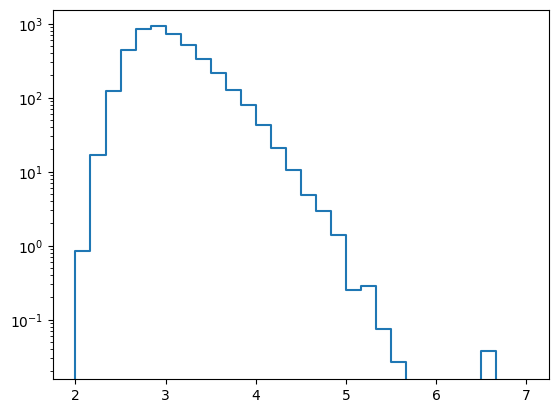

In [27]:
be = ana.expectations["det1"]
pred = ana.evaluate(dataset, model_parameters)[0]
hsum = pred["det1"].sum(axis=1)
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))
plt.semilogy()



In [22]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
key = jax.random.PRNGKey(0)
obs = {}
for k, v in hist.items():
    key, subkey = jax.random.split(key)
    obs[k] = jax.random.poisson(subkey, v)
obs = hist # asimov

In [ ]:
lh = lik.llh(obs, dataset, model_parameters)
lh_jit = jax.jit(lik.llh)


In [38]:
def eval_for_par(par_val, par_dict, llh_f):
    par_dict["astro_norm"]= par_val
    lh = llh_f(obs, dataset, par_dict)
    return lh


val_grad = jax.jit(jax.value_and_grad(eval_for_par, 0), static_argnums=(2,))


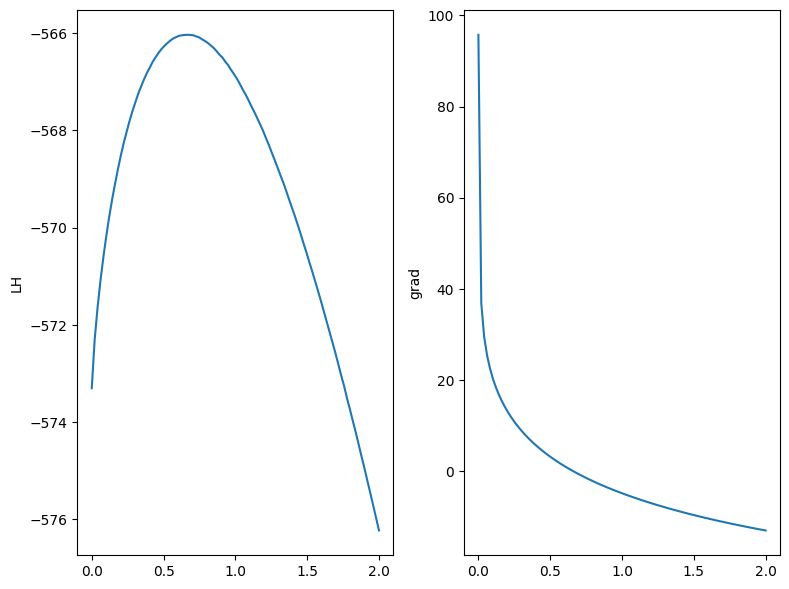

In [39]:
scan_vals = jnp.linspace(0, 2, 100)
lhs, grads = jax.vmap(val_grad, in_axes=(0, None, None))(scan_vals, model_parameters, lik_s.llh)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax1.plot(scan_vals, lhs)
ax1.set_ylabel("LH")
ax2.plot(scan_vals, grads)
ax2.set_ylabel("grad")
plt.tight_layout()

In [66]:
compressed_data = pyFF.clustering.compress_minibatch_kmeans(
    dataset["det1"],
    weight_keys=["baseline_weight", "conv_weight"],
    compression_factor=1.2)

In [67]:
compressed_data

{'true_energy': array([1.8343302e+03, 2.5894985e+06, 7.2754875e+06, ..., 9.7530688e+02,
        9.0866223e+02, 6.6252972e+02], shape=(82362,), dtype=float32),
 'log10_reco_energy': array([3.1906908, 3.9639666, 4.2161183, ..., 2.9903195, 3.220765 ,
        2.982142 ], shape=(82362,), dtype=float32),
 'cos_reco_zenith': array([ 0.32152098,  0.15831476,  0.1866615 , ...,  0.24333233,
        -0.10130988,  0.25054765], shape=(82362,), dtype=float32),
 'baseline_weight': array([0.00000000e+00, 7.21543247e+19, 3.54892869e+20, ...,
        2.35806502e+09, 1.19854848e+09, 5.90154816e+08], shape=(82362,)),
 'conv_weight': array([0.00000000e+00, 1.83698823e-04, 1.26611894e-05, ...,
        9.24043227e-02, 6.26354516e-02, 6.27221987e-02], shape=(82362,)),
 'e_scaling': array([1.0841914 , 1.0511297 , 1.0517098 , ..., 0.9888625 , 0.9278325 ,
        0.93984866], shape=(82362,), dtype=float32),
 'e_smearing': array([0.97514874, 1.0413941 , 0.97229916, ..., 0.9196886 , 1.0165894 ,
        0.9775544 ]

(array([0.00000000e+00, 9.99757588e-01, 1.74495373e+01, 1.32388748e+02,
        4.72158844e+02, 8.82311951e+02, 9.48561279e+02, 7.62839355e+02,
        5.21920898e+02, 3.41773193e+02, 2.15454834e+02, 1.25320801e+02,
        7.51147461e+01, 3.66191406e+01, 1.64614258e+01, 7.60058594e+00,
        2.57812500e+00, 7.00683594e-01, 2.78320312e-01, 6.10351562e-02,
        2.24609375e-02, 4.88281250e-04, 4.88281250e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([2.        , 2.16666651, 2.33333349, 2.5       , 2.66666675,
        2.83333349, 3.        , 3.16666675, 3.33333349, 3.5       ,
        3.66666675, 3.83333349, 4.        , 4.16666698, 4.33333349,
        4.5       , 4.66666698, 4.83333349, 5.        , 5.16666651,
        5.33333349, 5.50000048, 5.66666698, 5.83333349, 6.        ,
        6.16666698, 6.33333349, 6.5       , 6.66666698, 6.83333397,
        7.        ]),
 <BarContainer object of

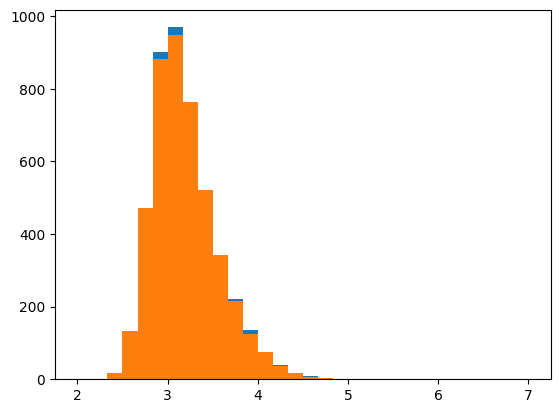

In [70]:
plt.hist(compressed_data["log10_reco_energy"], bins=be.binning.bin_edges[0], label="Compressed", weights=compressed_data["conv_weight"])
plt.hist(dataset["det1"]["log10_reco_energy"], bins=be.binning.bin_edges[0], label="Original", weights=dataset["det1"]["conv_weight"])

In [15]:
wrapped_lh = pyFF.minimizer.WrappedLLH(lik, obs, dataset, {}, {})

In [ ]:
dest_args = pyFF.minimizer.destructure_args(model_parameters, ana.exposed_parameters, {})
hess_func = jax.jit(jax.hessian(wrapped_lh))
hessian = hess_func(jnp.asarray(dest_args))
fisher = jnp.linalg.inv(hessian)
sns.heatmap(fisher, cmap="viridis", xticklabels=ana.exposed_parameters, yticklabels=ana.exposed_parameters)

In [22]:
fmin_and_grad = jax.jit(jax.value_and_grad(wrapped_lh))

In [49]:
import scipy.optimize

astro_scan = np.linspace(0, 3, 100)

scan_res = []

for astro in astro_scan:

    bounds = scipy.optimize.Bounds(
        [astro,      1.0, 0.9, 0.9, 0,      -1],
        [astro,      4.0, 1.1, 1.1, np.inf,  1]
    )

    res = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)
    scan_res.append(res.fun)

bounds = scipy.optimize.Bounds(
        [0,      1.0, 0.9, 0.9, 0,      -1],
        [np.inf,      4.0, 1.1, 1.1, np.inf,  1]
    )

free_fit = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)

Text(0, 0.5, 'Test Statistic')

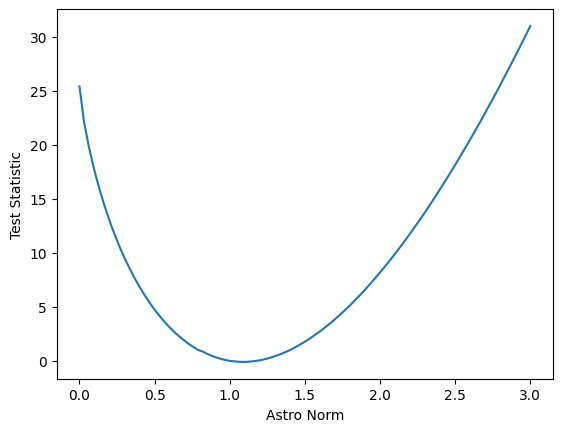

In [52]:
plt.plot(astro_scan, 2*(np.asarray(scan_res) - free_fit.fun))
plt.xlabel("Astro Norm")
plt.ylabel("Test Statistic")

In [14]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import nnx

class MLP(nnx.Module):
    """A simple CNN model."""

    def __init__(self, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(2, 32, rngs=rngs)
        self.linear2 = nnx.Linear(32, 32, rngs=rngs)
        self.out = nnx.Linear(32, 1, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear1(x))
        x = nnx.relu(self.linear2(x))
        x = nnx.sigmoid(self.out(x))
        return x
  

In [15]:
model = MLP(rngs=nnx.Rngs(0))

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

nn_in = jnp.vstack([
        input_variables["log10_reco_energy"],
        input_variables["cos_reco_zenith"],]).T

def loss_fn(model: MLP):
    summary_stat = model(nn_in)
    input_variables["summary_stat"] = summary_stat
    dataset = {"det1": input_variables}
    hist, hist_ssq = ana.evaluate(dataset, model_parameters)
    obs = hist
    wrapped_lh = pyFF.minimizer.WrappedLLH(lik, obs, dataset, {}, {})
    dest_args = pyFF.minimizer.destructure_args(model_parameters, ana.exposed_parameters, {})
    #hess_func = jax.jit(jax.hessian(wrapped_lh))
    #hessian = hess_func(jnp.asarray(dest_args))
    
    grad = jax.grad(wrapped_lh)(jnp.asarray(dest_args))
    fisher = jnp.outer(grad, grad)
    cov = jnp.linalg.inv(fisher)
    ts = jnp.linalg.trace(cov)

    return ts

@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
    loss, grads = grad_fn(model)
    metrics.update(loss=loss,)  
    optimizer.update(grads) 

@nnx.jit
def eval_step(model: MLP, metrics: nnx.MultiMetric):
    loss = loss_fn(model)
    metrics.update(loss=loss)  # In-place updates.


In [16]:
ts = nnx.jit(loss_fn)(model)

In [17]:
ts

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error preparing computation: Out of memory allocating 3907341534360 bytes.

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error preparing computation: Out of memory allocating 3907341534360 bytes.

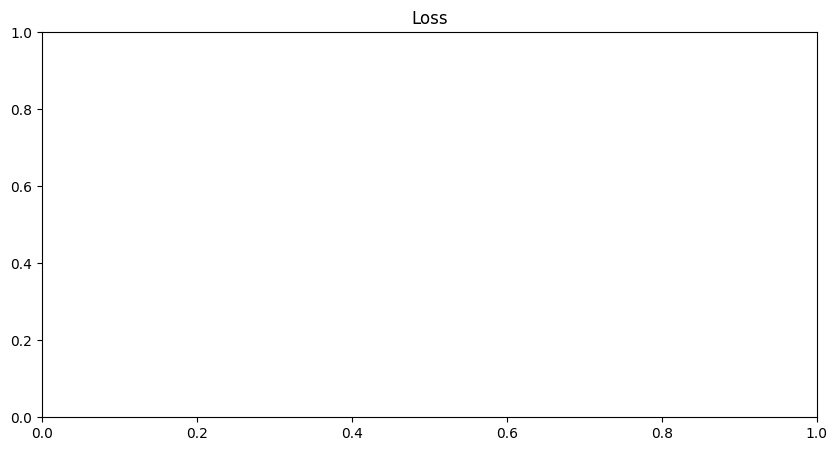

In [15]:
from IPython.display import clear_output

metrics_history = {
  'train_loss': [],
  'test_loss': [],

}

eval_every = 10
train_steps = 100

for step in range(train_steps):
    train_step(model, optimizer, metrics)
    
    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
        # Log the training metrics.
        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
        metrics.reset()  # Reset the metrics for the test set.


        eval_step(model, metrics)
       
        # Log the test metrics.
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset()  # Reset the metrics for the next training epoch.

        clear_output(wait=True)
        # Plot loss and accuracy in subplots
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        ax1.set_title('Loss')
        for dataset in ('train', 'test'):
            ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
        ax1.legend()
        plt.show()

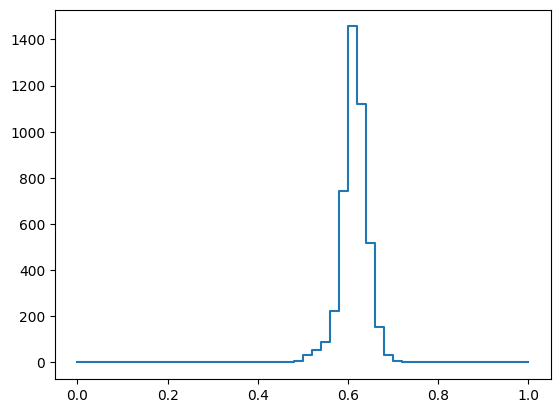

In [75]:
nn_in = jnp.vstack([
            input_variables["log10_reco_energy"],
            input_variables["cos_reco_zenith"],]).T
summary_stat = state.apply_fn({"params": state.params}, nn_in)[:, 0]
input_variables["summary_stat"] = summary_stat
dataset = {"det1": input_variables}
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
hsum = hist["det1"]
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))